In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [42]:
# Load your pre-trained model
model_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5"
model = keras.models.load_model(model_path)


In [43]:
# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data

# Example usage
filename_to_load = "03333"  # Replace with the specific filename you want to load
sampling_rate = 100
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


In [44]:
input_example.shape

(1000, 12)

In [45]:
# Ensure the correct input shape for the model
input_example = np.expand_dims(input_example, axis=-1)  # Add channel dimension
input_example = np.expand_dims(input_example, axis=0)   # Add batch dimension
input_example = np.transpose(input_example, (0, 2, 1, 3))  # Transpose dimensions


In [46]:
input_example.shape

(1, 12, 1000, 1)

In [52]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def grad_cam(layer_name, data, model):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]

    grads = tape.gradient(class_output, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

# Plot each lead separately with its corresponding heatmap overlay
leads = ["Lead-I", "Lead-II", "Lead-III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.figure(figsize=(16, 20))

for i, lead in enumerate(leads):
    lead_data = input_example[:, i:i+1, :, :]
    
    # Generate and plot the heatmap overlay for the current lead
    heatmap_resized = grad_cam("conv2d_19", lead_data, model)  # Adjust layer name if needed

    # Plot the original ECG signal for the current lead
    plt.subplot(6, 2, i + 1)
    plt.plot(np.arange(lead_data.shape[2]), lead_data[0, i, :, 0], color='black', linewidth=1)
    plt.title(f"{lead} Original ECG")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot the heatmap overlay for the current lead
    plt.subplot(6, 2, 12 + i + 1)
    plt.imshow(np.expand_dims(heatmap_resized, axis=0), cmap='hot', aspect="auto",
               extent=[0, 1000, lead_data.min()*1.05, lead_data.max()*1.05], alpha=0.5)
    plt.title(f"{lead} Grad-CAM Heatmap Overlay")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


ValueError: Input 0 of layer "model_20" is incompatible with the layer: expected shape=(None, 12, 1000, 1), found shape=(1, 1, 1000, 1)

<Figure size 1600x2000 with 0 Axes>

In [132]:
# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_9')  
output_layer = model.get_layer('dense_2')  


# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])


In [133]:
# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Compute the guided gradients and calculate the guided Grad-CAM heatmap
grads = tape.gradient(class_output, conv_outputs)
guided_grads = (grads[0] * conv_outputs[0])
heatmap = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

# Normalize the heatmap values
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap = cv2.resize(heatmap, (input_shape[1], input_shape[0]))


In [134]:
input_example.shape

(1, 12, 1000, 1)

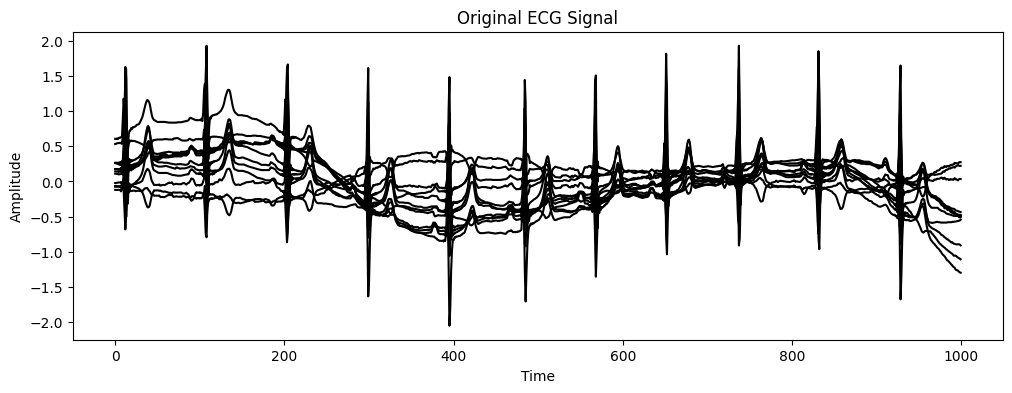

In [114]:
# Display the original input (ECG signal)
plt.figure(figsize=(12, 4))
num_channels = input_example.shape[1]
num_points = input_example.shape[2]
plt.plot(np.arange(num_points), input_example[0, :, :, 0].T, color='black')  # Transpose to match dimensions
plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


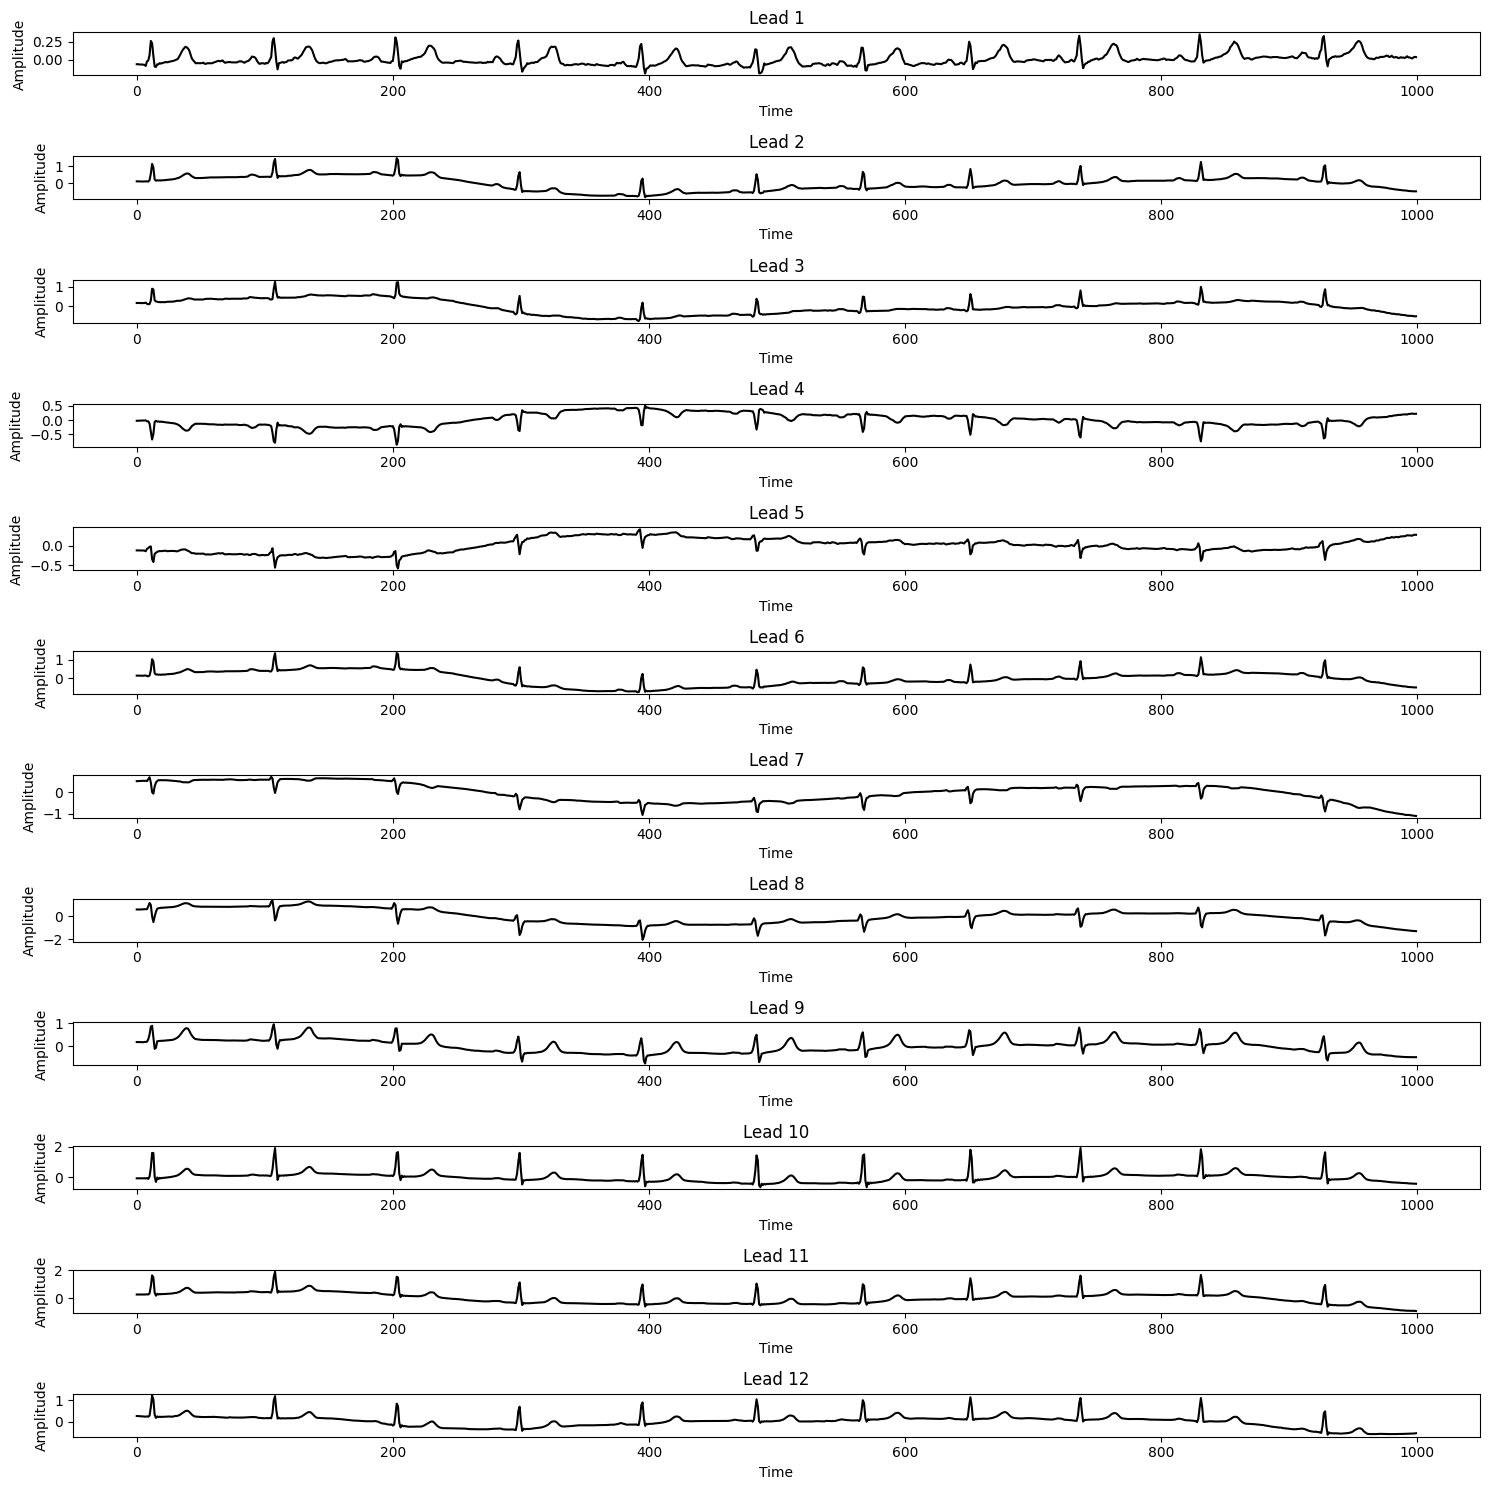

In [138]:
import matplotlib.pyplot as plt

# Assuming input_example has shape (1, 12, 1000, 1)
input_example = np.squeeze(input_example)  # Remove singleton dimensions

# Display each lead in a separate subplot
num_leads = input_example.shape[0]

plt.figure(figsize=(15, 15))

for i in range(num_leads):
    plt.subplot(num_leads, 1, i+1)
    plt.plot(input_example[i].flatten(), color='black')
    plt.title(f'Lead {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1446204/2835203417.py:119: RuntimeWarning: invalid value encountered in divide
  heatmap_lead = np.maximum(heatmap_lead, 0) / np.max(heatmap_lead)
/tmp/ipykernel_1446204/2835203417.py:137: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


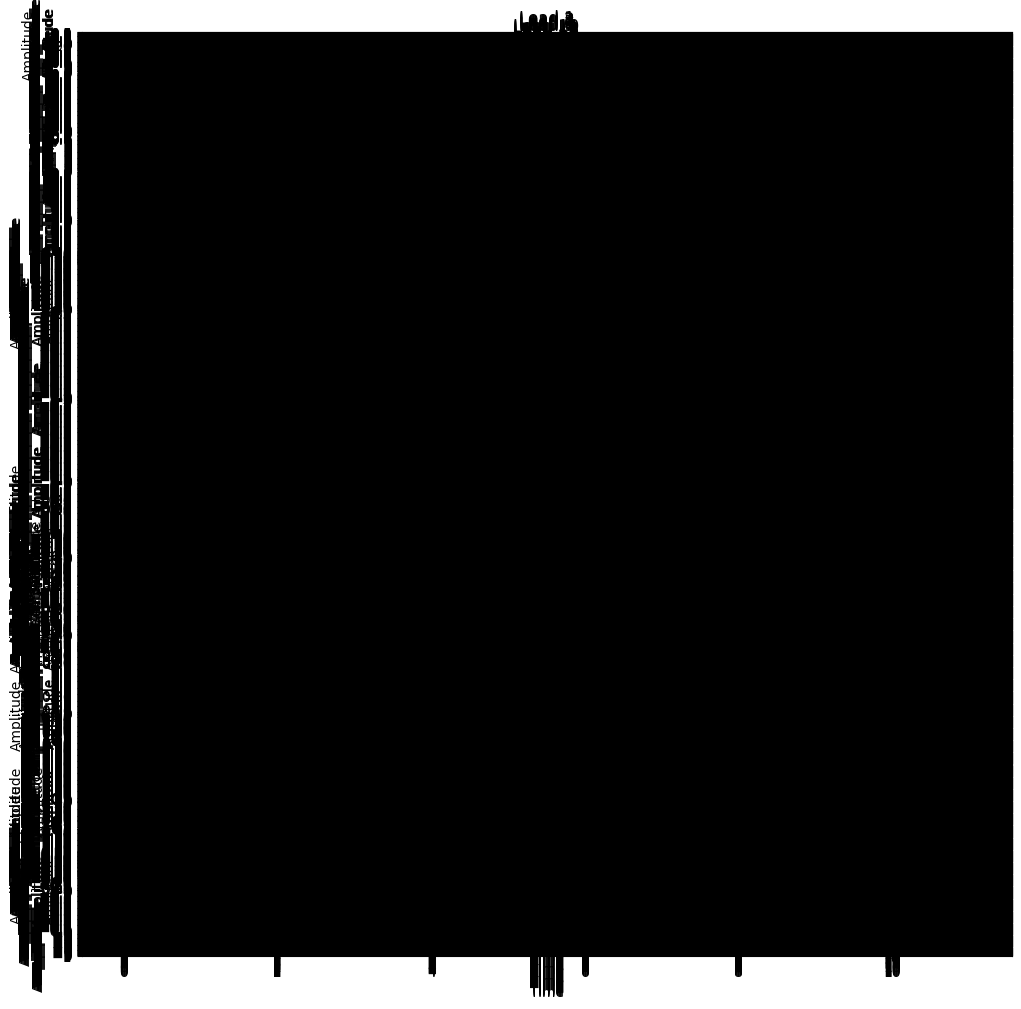

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your pre-trained model
model_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5"
model = keras.models.load_model(model_path)

# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_9')  
output_layer = model.get_layer('dense_2')  

# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data

# Example usage
filename_to_load = "03333"  # Replace with the specific filename you want to load
sampling_rate = 100
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])


# Ensure the correct input shape for the model
input_example = np.expand_dims(input_example, axis=-1)  # Add channel dimension
input_example = np.expand_dims(input_example, axis=0)   # Add batch dimension
input_example = np.transpose(input_example, (0, 2, 1, 3))  # Transpose dimensions

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Compute the guided gradients and calculate the guided Grad-CAM heatmap
grads = tape.gradient(class_output, conv_outputs)
guided_grads = (grads[0] * conv_outputs[0])
heatmap = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

# Normalize the heatmap values
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap = cv2.resize(heatmap, (input_shape[1], input_shape[0]))

# Convert the heatmap to RGB using matplotlib's 'jet' colormap
# heatmap_rgb = plt.cm.jet(heatmap)[:, :, :3]  # Use only the RGB channels
heatmap_rgb = plt.cm.viridis(heatmap)[:, :, :3]  # Use only the RGB channels, you can choose another colormap


# Superimpose the heatmap on the original ECG signal
superimposed_img = heatmap_rgb * 0.4 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.6
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]



# # Display the original input, heatmap, and superimposed image
# plt.figure(figsize=(12, 12))

# # Display each lead in a separate subplot
# num_leads = input_example.shape[2]

# for i in range(num_leads):
#     plt.subplot(num_leads, 1, i+1)
#     plt.plot(input_example[0, :, i, 0], color='black')  # Plot the original ECG signal

#     # Resize the heatmap to match the original lead size
#     heatmap_lead = cv2.resize(heatmap, (input_example.shape[2], input_example.shape[1]))
#     heatmap_lead = heatmap_lead[:, i]  # Select the heatmap for the current lead

#     # Normalize the heatmap values
#     heatmap_lead = np.maximum(heatmap_lead, 0) / np.max(heatmap_lead)

#     # Apply the heatmap to the original signal
#     superimposed_img_lead = heatmap_lead * 0.4 + input_example[0, :, i, 0] * 0.6
#     superimposed_img_lead = np.clip(superimposed_img_lead, 0, 1)  # Clip values to the valid range [0, 1]

#     plt.plot(superimposed_img_lead, color='red', alpha=0.5)  # Overlay the Grad-CAM heatmap
#     plt.title(f'Lead {i+1}')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')

# plt.tight_layout()
# plt.show()


# Display the original input, heatmap, and superimposed image
plt.figure(figsize=(12, 12))

# Display each lead in a separate subplot
num_leads = input_example.shape[2]

for i in range(num_leads):
    plt.subplot(num_leads, 1, i+1)
    # plt.plot(input_example[0, :, i, 0], color='black')  # Plot the original ECG signal
    # Plot the original ECG signal in color
    plt.plot(np.arange(input_example.shape[1]), input_example[0, :, i, 0], color='black')


    # Resize the heatmap to match the original lead size
    heatmap_lead = cv2.resize(heatmap, (input_example.shape[2], input_example.shape[1]))
    heatmap_lead = heatmap_lead[:, i]  # Select the heatmap for the current lead

    # Normalize the heatmap values
    heatmap_lead = np.maximum(heatmap_lead, 0) / np.max(heatmap_lead)

    # Apply the heatmap to the original signal
    superimposed_img_lead = heatmap_lead * 0.4 + input_example[0, :, i, 0] * 0.6
    superimposed_img_lead = np.clip(superimposed_img_lead, 0, 1)  # Clip values to the valid range [0, 1]

    # Plot the original ECG signal
    # plt.plot(input_example[0, :, i, 0], color='black', alpha=0.5)
    # Plot the original ECG signal in color
    plt.plot(np.arange(input_example.shape[1]), input_example[0, :, i, 0], color='black')

    # Overlay the Grad-CAM heatmap
    plt.plot(superimposed_img_lead, color='red', alpha=0.5)

    plt.title(f'Lead {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [36]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = sys.argv[1]
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# def grad_cam(input_model, image, category_index, layer_name):
#     model = Sequential()
#     model.add(input_model)

#     nb_classes = 5
#     target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
#     model.add(Lambda(target_layer,
#                      output_shape = target_category_loss_output_shape))

#     loss = K.sum(model.layers[-1].output)

#     # conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
#     conv_output = [l.output for l in model.layers[0].layers if l.name == layer_name]
#     if conv_output:
#         conv_output = conv_output[0]
#     else:
#         raise ValueError(f"No layer with name '{layer_name}' found.")
    
#     with tf.GradientTape() as tape:
#         grads = normalize(tape.gradient(loss, conv_output))
#     gradient_function = tf.keras.backend.function([model.layers[0].input], [conv_output, grads])

#     output, grads_val = gradient_function([image])
#     output, grads_val = output[0, :], grads_val[0, :, :, :]

#     weights = np.mean(grads_val, axis = (0, 1))
#     cam = np.ones(output.shape[0 : 2], dtype = np.float32)

#     for i, w in enumerate(weights):
#         cam += w * output[:, :, i]

#     cam = cv2.resize(cam, (224, 224))
#     cam = np.maximum(cam, 0)
#     heatmap = cam / np.max(cam)

#     #Return to BGR [0..255] from the preprocessed image
#     image = image[0, :]
#     image -= np.min(image)
#     image = np.minimum(image, 255)

#     cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
#     cam = np.float32(cam) + np.float32(image)
#     cam = 255 * cam / np.max(cam)
#     return np.uint8(cam), heatmap
def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 5
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape=target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)

    # Get the output tensor of the specified layer
    layer_dict = dict([(layer.name, layer) for layer in model.layers[0].layers])
    if layer_name not in layer_dict:
        raise ValueError(f"No layer with name '{layer_name}' found.")
    
    conv_output = layer_dict[layer_name].output
    
    # Use GradientTape to compute the gradient
    with tf.GradientTape() as tape:
        grads = normalize(tape.gradient(loss, conv_output))

    gradient_function = tf.keras.backend.function([model.layers[0].input], [conv_output, grads])
    output, grads_val = gradient_function([image])

    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


In [2]:
# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data

# Example usage
filename_to_load = "03333"  # Replace with the specific filename you want to load
sampling_rate = 100
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


In [3]:

# preprocessed_input = load_image(sys.argv[1])
x = np.transpose(input_example, (1, 0))                 # transpose matrix
x = np.expand_dims(x, axis=(0, -1))                # Add another channel on left and right
# Load your pre-trained model
model_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5"
model = keras.models.load_model(model_path)
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']

predictions = model.predict(x)


print("Sample belongs to following classes:")
for i in range(5):
    if predictions[0][i] >= 0.5 :
        print(" * " + classes[i])

2024-01-16 06:05:33.923905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13718 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-01-16 06:05:40.072522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-01-16 06:05:42.754183: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 06:05:44.129698: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 10s 10s/step
Sample belongs to following classes:
 * Normal ECG


In [44]:
x.shape

(1, 12, 1000, 1)

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import numpy as np
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Lambda


In [128]:
import tensorflow as tf
import numpy as np

def compute_gradients_and_output(model, input_data, layer_name):
    # Create a model that outputs the specified layer's activations
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Get the activations of the specified layer
    with tf.GradientTape() as tape:
        conv_output = intermediate_model(input_data)
    grads = tape.gradient(conv_output, input_data)

    return grads, conv_output

# WORKING CAM 
def grad_cam_ecg(model, ecg_data, category_index, layer_name):
    # Convert ecg_data to a TensorFlow tensor
    ecg_data_tensor = tf.convert_to_tensor(ecg_data, dtype=tf.float32)

    # Get model predictions
    predictions = model(ecg_data_tensor)

    # Get the predicted class index
    predicted_class = category_index if category_index is not None else tf.argmax(predictions[0])

    # Compute gradients and output
    grads, conv_output = compute_gradients_and_output(model, ecg_data_tensor, layer_name)

    # Handle the case where grads is None
    if grads is None:
        grads = tf.ones_like(ecg_data_tensor)  # Provide a default gradient

    # Compute Grad-CAM along the time dimension
    weights = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

    # Apply ReLU and normalize
    cam = tf.nn.relu(cam)
    cam /= tf.reduce_max(cam)

    # Check if cam is 1D, reshape to 2D
    if len(cam.shape) == 1:
        cam = tf.reshape(cam, (1, -1))

    return cam.numpy(), conv_output.numpy()


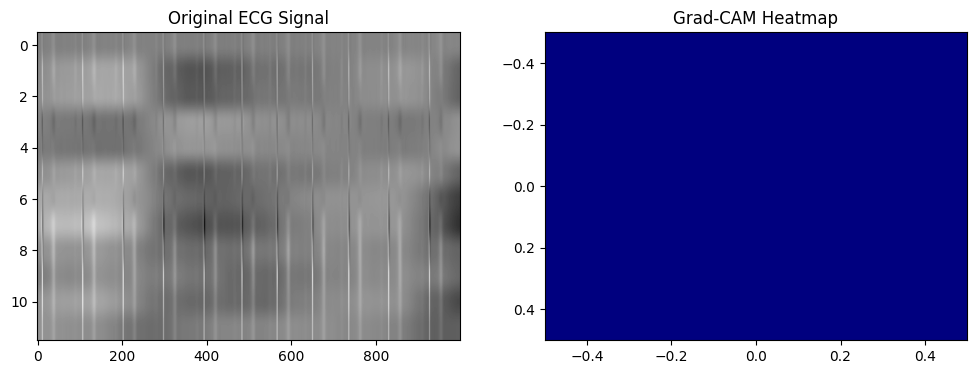

In [131]:
# Example usage
model_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5"
model = tf.keras.models.load_model(model_path)
ecg_data_example = load_raw_data("03333", 100, "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/")

# Ensure the correct input shape for the model
ecg_data_example = np.expand_dims(ecg_data_example, axis=-1)  # Add channel dimension
ecg_data_example = np.expand_dims(ecg_data_example, axis=0)   # Add batch dimension
ecg_data_example = np.transpose(ecg_data_example, (0, 2, 1, 3))  # Transpose dimensions

predicted_class = np.argmax(predictions)

cam, heatmap = grad_cam_ecg(model, ecg_data_example, predicted_class, 'dense_2')

# Display the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Plot the original ECG signal without transposing
plt.imshow(ecg_data_example[0, :, :, 0], cmap='gray', aspect='auto')
plt.title('Original ECG Signal')

plt.subplot(1, 2, 2)
# Transpose the Grad-CAM and display
plt.imshow(cam, cmap='jet', aspect='auto')
plt.title('Grad-CAM Heatmap')

plt.show()


In [120]:
# Print the names of all layers in the model
for layer in model.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
re_lu
max_pooling2d
conv2d_2
batch_normalization_1
re_lu_1
max_pooling2d_1
conv2d_1
conv2d_4
conv2d_3
batch_normalization_2
add
re_lu_2
max_pooling2d_2
conv2d_6
batch_normalization_3
re_lu_3
max_pooling2d_3
conv2d_5
conv2d_8
conv2d_7
batch_normalization_4
add_1
re_lu_4
max_pooling2d_4
conv2d_9
batch_normalization_5
re_lu_5
global_average_pooling2d
flatten
dense
batch_normalization_6
re_lu_6
dropout
dense_1
batch_normalization_7
re_lu_7
dropout_1
dense_2


In [82]:
predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam_ecg(model, x, predicted_class, "conv2d_9")
cv2.imwrite("gradcam.jpg", cam)

AttributeError: 'KerasTensor' object has no attribute '_id'

In [44]:




register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([x, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

AttributeError: 'KerasTensor' object has no attribute '_id'

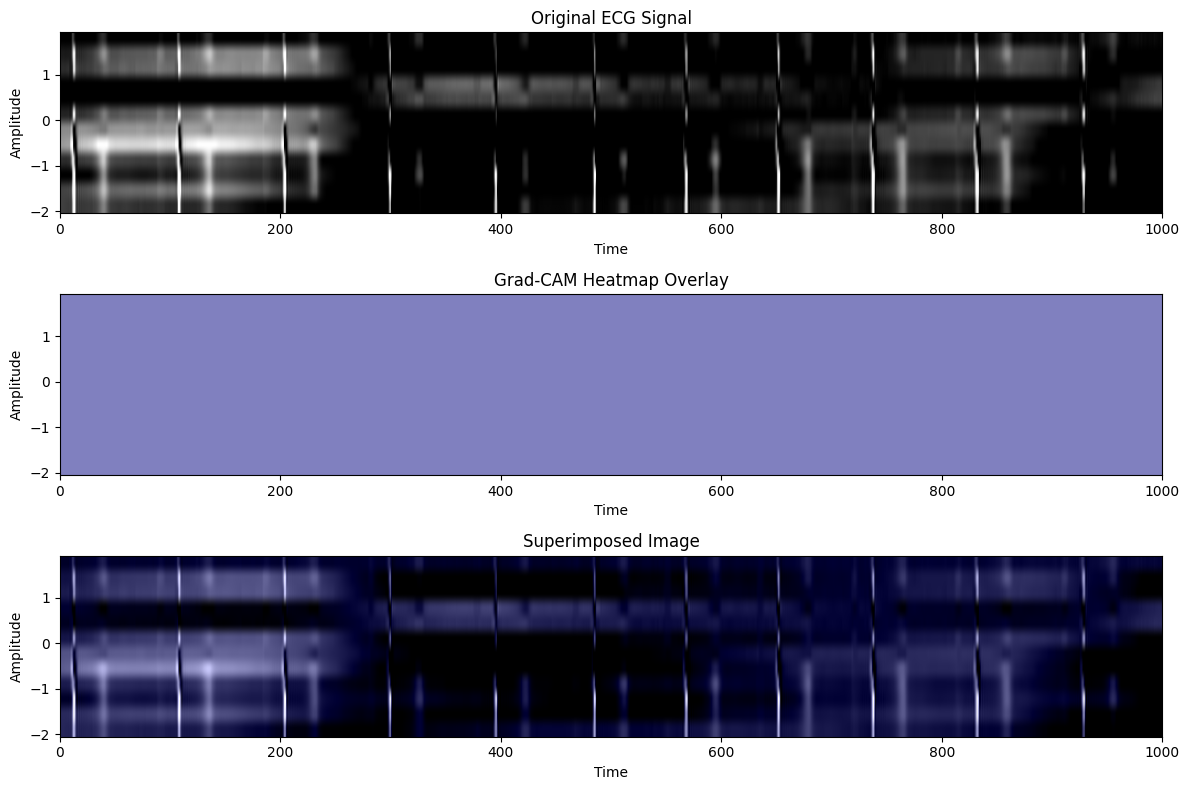

In [117]:
# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_9')  
output_layer = model.get_layer('dense_2')  

# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Compute the guided gradients and calculate the guided Grad-CAM heatmap
grads = tape.gradient(class_output, conv_outputs)
guided_grads = (grads[0] * conv_outputs[0])
heatmap = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

# Normalize the heatmap values
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap_resized = cv2.resize(heatmap, (input_shape[1], input_shape[0]))

# Convert the heatmap to RGB using matplotlib's 'jet' colormap
heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# Superimpose the heatmap on the original ECG signal
superimposed_img = heatmap_rgb * 0.4 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.6
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# Convert the original ECG signal to RGB
original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]

# Plot the figures with RGB colors
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.imshow(original_ecg_rgb, extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto')
plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(heatmap_rgb, extent=[0, num_points, np.min(input_example), np.max(input_example)], alpha=0.5, aspect='auto')
plt.title('Grad-CAM Heatmap Overlay')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(superimposed_img, extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto')
plt.title('Superimposed Image')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

